In [2]:
from utils import train_utils, data_utils, anchor_utils, bbox_utils
import tensorflow as tf
from config import *
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL']= '2'

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as error:
        print(error)

1 Physical GPUs, 1 Logical GPUs


In [5]:
model, _, _, _ = train_utils.get_model()

make new model
Model: YOLOv4


In [6]:
dataloader = data_utils.DataLoader(batch_size=BATCH_SIZE)
test_dataset = dataloader('train', use_label=True)

/home/hs/anaconda3/envs/tf28/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset: custom train
./data/custom/train.tfrecord is exist


In [7]:
data = next(iter(test_dataset))

In [8]:
images, s_grids, m_grids, l_grids, labels = data

In [20]:
def draw(image, p1, p2, color, width, box=True):
    if box:
        cv2.rectangle(image, p1,p2, color, width)
    else:
        c = ((p1 + p2)*0.5).astype(np.int32)
        cv2.circle(image, c, width, color, width)

2 2 0 1


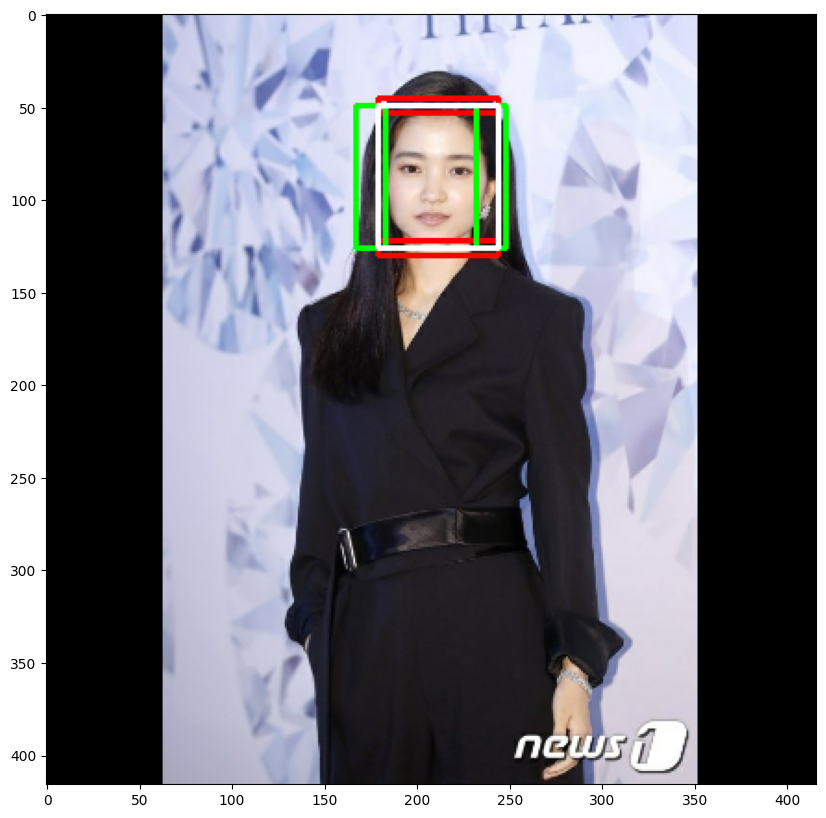

In [21]:
plt.figure(figsize=(10,10))
for i, (image, s_grid, m_grid, l_grid, label) in enumerate(zip(images.numpy()*255, s_grids, m_grids, l_grids, labels)):
    if i==2:
        image = image.astype(np.int32)

        s_grid = np.reshape(s_grid, [-1, 11])
        m_grid = np.reshape(m_grid, [-1, 11])
        l_grid = np.reshape(l_grid, [-1, 11])

        ss = 0 
        for s in s_grid:
            if s[4] != 0:
                p1 = (s[..., :2] - 0.5 * s[..., 2:4]).astype(np.int32)
                p2 = (s[..., :2] + 0.5 * s[..., 2:4]).astype(np.int32)
                draw(image, p1, p2, (255, 0, 0), 2)
                ss += 1
        
        mm = 0
        for m in m_grid:
            if m[4] != 0:
                p1 = (m[..., :2] - 0.5 * m[..., 2:4]).astype(np.int32)
                p2 = (m[..., :2] + 0.5 * m[..., 2:4]).astype(np.int32)
                draw(image, p1, p2, (0, 255, 0), 2)
                mm += 1

        ll = 0
        for l in l_grid:
            if l[4] != 0:
                p1 = (l[..., :2] - 0.5 * l[..., 2:4]).astype(np.int32)
                p2 = (l[..., :2] + 0.5 * l[..., 2:4]).astype(np.int32)
                draw(image, p1, p2, (0, 0, 255), 2)
                ll += 1

        gg = 0
        for g in label.numpy():
            if g[4] != 0:
                p1 = (g[..., :2] - 0.5 * g[..., 2:4]).astype(np.int32)
                p2 = (g[..., :2] + 0.5 * g[..., 2:4]).astype(np.int32)
                draw(image, p1, p2, (255, 255, 255), 2)
                gg += 1
        plt.imshow(image)
        print(ss, mm, ll, gg)
plt.show()

In [9]:
out = model(images[0:1])

In [11]:
anchors = anchor_utils.get_anchors_xywh(ANCHORS, STRIDES, IMAGE_SIZE)

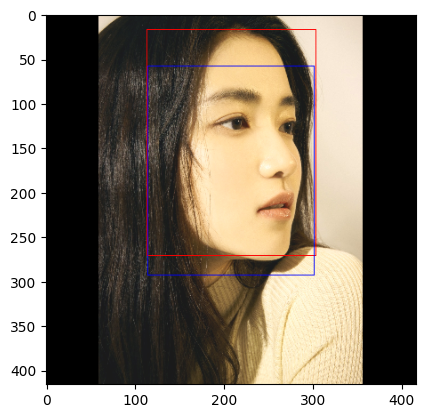

In [17]:
for g, anchor, stride in zip(out, anchors, STRIDES):
    i = (images[0].numpy()*255).astype(np.uint8)
    bbox = g[..., :4]
    conf = g[..., 4:5]
    prob = g[..., 5:]
    pred_xy = tf.sigmoid(bbox[..., :2]) + anchor[..., :2]
    pred_wh = tf.exp(bbox[..., 2:4]) * anchor[..., 2:4]
    pred_bbox = tf.concat([pred_xy, pred_wh], -1) * stride

    best_c = 0.
    best_box = [[0,0],[0,0]]
    for b, c, p in zip(pred_bbox.numpy().reshape(-1, 4), conf.numpy().reshape(-1, 1), prob.numpy().reshape(-1, 1)):
        
        if c>0.06:
            p1 = (b[:2] - 0.5 * b[2:4]).astype(np.int32)
            p2 = (b[:2] + 0.5 * b[2:4]).astype(np.int32)
            cv2.rectangle(i, p1, p2, (255, 0, 0), 1)
            if best_c < c:
                best_c = c
                best_box = [p1, p2]

    cv2.rectangle(i, best_box[0], best_box[1], (0, 0, 255), 1)


plt.imshow(i)
plt.show()

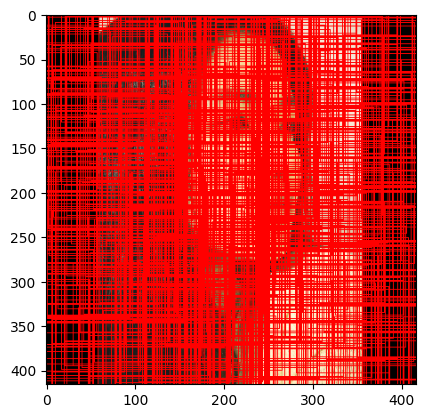

In [13]:
for g, anchor, stride in zip(out, anchors, STRIDES):
    i = (images[0].numpy()*255).astype(np.uint8)
    bbox = g[..., :4]
    conf = g[..., 4:5]
    prob = g[..., 5:]
    pred_xy = tf.sigmoid(bbox[..., :2]) + anchor[..., :2]
    pred_wh = tf.exp(bbox[..., 2:4]) * anchor[..., 2:4]
    pred_bbox = tf.concat([pred_xy, pred_wh], -1) * stride
    for b, c, p in zip(pred_bbox.numpy().reshape(-1, 4), conf.numpy().reshape(-1, 1), prob.numpy().reshape(-1, 1)):
        if True or c>0.01:
            p1 = (b[:2] - 0.5 * b[2:4]).astype(np.int32)
            p2 = (b[:2] + 0.5 * b[2:4]).astype(np.int32)
            cv2.rectangle(i, p1, p2, (255, 0, 0), 1)

    for a in anchor.numpy().reshape(-1, 4)*stride:
        p1 = (a[:2] - 0.5 * a[2:4]).astype(np.int32)
        p2 = (a[:2] + 0.5 * a[2:4]).astype(np.int32)
        # cv2.rectangle(i, p1, p2, (0, 255, 0), 1)


plt.imshow(i)
plt.show()

In [138]:
def bbox_iou(bbox1, bbox2, xywh=True, iou_type='iou', eps=EPS, inf=INF, image_size=IMAGE_SIZE):
    if xywh:
        area1 = tf.reduce_prod(bbox1[..., 2:], -1)
        area2 = tf.reduce_prod(bbox2[..., 2:], -1)
        bbox1 = tf.concat([bbox1[..., :2] - bbox1[..., 2:] * 0.5, bbox1[..., :2] + bbox1[..., 2:] * 0.5], -1)
        bbox2 = tf.concat([bbox2[..., :2] - bbox2[..., 2:] * 0.5, bbox2[..., :2] + bbox2[..., 2:] * 0.5], -1)
    else:
        area1 = tf.reduce_prod(bbox1[..., 2:] - bbox1[..., :2], -1)
        area2 = tf.reduce_prod(bbox2[..., 2:] - bbox2[..., :2], -1)

    Left_Top = tf.maximum(bbox1[..., :2], bbox2[..., :2])
    Right_Bottom = tf.minimum(bbox1[..., 2:], bbox2[..., 2:])

    inter_section = tf.maximum(Right_Bottom - Left_Top, 0.0)
    inter_area = tf.reduce_prod(inter_section, -1)
    union_area = tf.maximum(area1 + area2 - inter_area, eps)

    iou = inter_area / union_area

    if iou_type in ['giou', 'diou', 'ciou']:
        c_Left_Top = tf.minimum(bbox1[..., :2], bbox2[..., :2])
        c_Right_Bottom = tf.maximum(bbox1[..., 2:], bbox2[..., 2:])
        if iou_type == 'giou':
            c_area = tf.maximum(tf.reduce_prod(c_Right_Bottom - c_Left_Top, -1), eps)
            giou = iou - (c_area - union_area)/c_area
            return giou
        
        elif iou_type in ['diou', 'ciou']:
            center_xy1 = (bbox1[..., :2] + bbox1[..., 2:]) * 0.5
            center_xy2 = (bbox2[..., :2] + bbox2[..., 2:]) * 0.5
            p_square = tf.reduce_sum(tf.minimum(tf.square(center_xy1 - center_xy2), inf), -1)
            c_square = tf.reduce_sum(tf.minimum(tf.maximum(tf.square(c_Right_Bottom - c_Left_Top), eps), inf), -1)

            if iou_type == 'diou':
                diou = iou - p_square/c_square
                return diou
            
            w1 = bbox1[..., 2] - bbox1[..., 0]
            h1 = tf.maximum(bbox1[..., 3] - bbox1[..., 1], eps)
            w2 = bbox2[..., 2] - bbox2[..., 0]
            h2 = tf.maximum(bbox2[..., 3] - bbox2[..., 1], eps)

            v = 4/tf.square(np.pi) * tf.square(tf.math.atan(w1/h1) - tf.math.atan(w2/h2))
            alpha = v/tf.maximum((1.0 - iou + v), eps)
            ciou = iou - p_square/c_square - alpha*v
            return ciou
    return iou

In [142]:
gt = np.array([[100, 100, 300, 200]], np.float32)
pr = np.array([[x, x, 150, 70] for x in range(0, 10)], np.float32)

In [143]:
iou = bbox_iou(gt, pr, iou_type='ciou')

tf.Tensor(
[160850. 159732. 158618. 157508. 156402. 155300. 154202. 153108. 152018.
 150932.], shape=(10,), dtype=float32)
tf.Tensor([20000. 19602. 19208. 18818. 18432. 18050. 17672. 17298. 16928. 16562.], shape=(10,), dtype=float32)
tf.Tensor(
[0.00928691 0.00928691 0.00928691 0.00928691 0.00928691 0.00928691
 0.00928691 0.00928691 0.00928691 0.00928691], shape=(10,), dtype=float32)


In [144]:
iou

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-0.05826832, -0.05404497, -0.04977563, -0.04545984, -0.04109712,
       -0.03668696, -0.03222888, -0.02772234, -0.02316683, -0.01856178],
      dtype=float32)>

In [133]:
coord_scale = 2.0 - 1.0 * tf.reduce_prod(pr[..., 2:4]/400, -1, keepdims=True)

In [113]:
coord_scale

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.9375],
       [1.9375],
       [1.9375],
       [1.9375],
       [1.9375],
       [1.9375],
       [1.9375],
       [1.9375],
       [1.9375],
       [1.9375]], dtype=float32)>

In [ ]:
triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to
이거 에러 잡기